# Tutorial 1: Hospital
## 1. Specify Input

In [1]:
data_path = 'data/hospital.csv'
out_path = 'results/'
out_dc_name = 'hospital_constraints.txt'
GLD = True

## 2. Initialize Model and Load Data

In [2]:
from profiler.profiler import Profiler
from profiler.detector.helper import process_heatmap
import datetime
import os

In [3]:
session = 'demo'

In [4]:
pf = Profiler(use_db=False, ID=session)

INFO:profiler.utility:[3.81469726562e-06] START



In [5]:
# dropna: if set to true, it will drop any tuple with null values
# dropcol: drop columns by list of column names
# workers: number of processors used for multiprocessing
pf.load_data(input_type='file', path=data_path, 
             dropna=False, dropcol=['Address3'], fillna=True,
             use_embedding=True, embedding_size=20, workers=10)

INFO:profiler.utility:[0.0161068439484] Preprocess Data start

INFO:profiler.dataEngine:Loaded table
INFO:profiler.dataEngine:Preprocessing Data...
INFO:profiler.dataEngine:inferred types of attributes: {
    "City": "embeddable_categorical", 
    "Stateavg": "embeddable_categorical", 
    "Address1": "embeddable_categorical", 
    "Address2": "categorical", 
    "ZipCode": "embeddable_categorical", 
    "HospitalOwner": "embeddable_categorical", 
    "Sample": "embeddable_categorical", 
    "State": "categorical", 
    "Score": "embeddable_categorical", 
    "PhoneNumber": "embeddable_categorical", 
    "Condition": "embeddable_categorical", 
    "ProviderNumber": "embeddable_categorical", 
    "CountyName": "embeddable_categorical", 
    "EmergencyService": "categorical", 
    "MeasureName": "embeddable_categorical", 
    "HospitalName": "embeddable_categorical", 
    "MeasureCode": "embeddable_categorical", 
    "HospitalType": "embeddable_categorical"
}
INFO:profiler.dataEngine:Tab

### [Optional] Change the Data Type of Attributes
#### Data Types
* **numeric**: reason the differences by examing if |t1.A - t2.A|/max(differences of all pairs of tuples in A)) <= error bound or by examing user defined function f: (R^n, R^n) -> [0,1]^n (see section 5 for an example of user-defined function)
* **categorical**: reason the differences by examing t1.A == t2.A
* **embeddable_categorical**: reason the differences by examing cosine_distance(embed(t1.A), embed(t2.A))

#### Change Data Types
* In example dataset, it contains noises like "537x5" as a zip code, so there has no columns recognized as numerical. 
* In this case, you have the option to force it back to numeric. But be careful that values like "537x5" will be recognized as NaN. 
* you can also change data type to 'embeddable_categorical' if you want to use word embedding over the attribute. 

In [6]:
pf.change_dtypes(['ZipCode','PhoneNumber','State'], ['numeric','categorical','embeddable_categorical'])

INFO:profiler.dataEngine:updated types of ZipCode to 'numeric'
INFO:profiler.dataEngine:updated types of PhoneNumber to 'categorical'
INFO:profiler.dataEngine:updated types of State to 'embeddable_categorical'


### load embedding

In [7]:
pf.load_embedding()

INFO:profiler.utility:[0.0890889167786] Load Embedding start

INFO:profiler.utility:[0.78759098053] Load Embedding execution time: 0.698502063751



## 3. Run GLD

In [8]:
# save_heatmap: options are 'csv' and 'none'
# alpha_cov: parameter controlling sparsity of cov in glasso
# alpha_corr: parameter controlling sparsity of corr in glasso
# differences: is set to true, doing training data transformation
# params for GLD only (set differences to true):
# sample_frac: take samples with certain fraction when creating training data in each iteration
# total_frac: take samples of training data after concatenating all training data
# user_defined: user defined function for numeric attribute
# error_bound: paramater used for default function for numeric attribute
model_run_time = pf.run_graphical_lasso(hm_path=out_path, save_heatmap='csv',
                                        sample_frac=1, total_frac=1,
                                        alpha_cov=0.005, differences=GLD,
                                        decompose=True, undirected=False,
                                        use_cov=True, use_corr=True,
                                        sort_training_data=True,
                                        error_bound=0.0001, user_defined=None)

INFO:profiler.utility:[0.806795835495] Create Training Data start

INFO:profiler.dataEngine:Creating Joint Training Data (total_frac = 1.000000, sample_frac = 1.000000)
INFO:profiler.dataEngine:multiplier: 18
100%|██████████| 18/18 [00:00<00:00, 139.99it/s]
INFO:profiler.dataEngine:Training data size: (16995, 37)
100%|██████████| 16995/16995 [00:04<00:00, 3684.40it/s]
INFO:profiler.detector.glassodetector:Treat CountyName as embeddable categorical
100%|██████████| 16995/16995 [00:04<00:00, 3883.15it/s]
INFO:profiler.detector.glassodetector:Treat Score as embeddable categorical
100%|██████████| 16995/16995 [00:04<00:00, 4069.34it/s]
INFO:profiler.detector.glassodetector:Treat Stateavg as embeddable categorical
100%|██████████| 16995/16995 [00:03<00:00, 5248.22it/s]
INFO:profiler.detector.glassodetector:Treat Address1 as embeddable categorical
100%|██████████| 16995/16995 [00:03<00:00, 5658.91it/s]
INFO:profiler.detector.glassodetector:Treat Condition as embeddable categorical
100%|█████

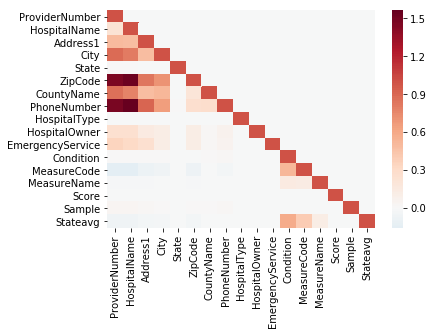

In [14]:
# if there has no outputs, just rerun this cell
pf.visualize_heatmap(pf.heatmap['cov'], save=False, title=None, filename="hospital_heatmap.png")

## 4. Generate FDs

In [10]:
# out_dc: if set to true, will write dcs to file specified by out_path and out_name
# display: if set to true, will print FD in the format of LHS -> RHS

# above_threshold and topk are exclusive options!
# above_threshold: if set to true, will filter the heatmaps with certain threshold, then output FDs
# t0: threshold when above_threshold set to true
# topk: if set to true, will output FDs with dimension up to k on the LHS

space, time, count = process_heatmap(pf.heatmap['cov'], out_dc=False, outfile=os.path.join(out_path, out_dc_name),
                                     normalize=False, take_abs=True, subsets=False,
                                     above_threshold=True, t0=0.3, 
                                     topk=False, k=6,
                                     display=True)

INFO:profiler.helper:Execution Time: 0.00973606109619 Output 8 Candidates


[ProviderNumber,HospitalName] -> [Address1]
[ProviderNumber,HospitalName,Address1] -> [City]
[ProviderNumber,HospitalName,Address1,City] -> [ZipCode]
[ProviderNumber,HospitalName,Address1,City] -> [CountyName]
[ProviderNumber,HospitalName,Address1,City] -> [PhoneNumber]
[ProviderNumber,HospitalName] -> [EmergencyService]
[Condition] -> [MeasureCode]
[Condition,MeasureCode] -> [Stateavg]


In [11]:
space, time, count = process_heatmap(pf.heatmap['cov'], out_dc=True, outfile=os.path.join(out_path, session + '_' +out_dc_name),
                                     normalize=False, take_abs=True, subsets=True,
                                     above_threshold=True, t0=0.3, 
                                     topk=False, k=6,
                                     display=True)

INFO:profiler.helper:Execution Time: 0.014967918396 Output 62 Candidates


[ProviderNumber] -> [Address1]
[HospitalName] -> [Address1]
[ProviderNumber,HospitalName] -> [Address1]
[ProviderNumber] -> [City]
[HospitalName] -> [City]
[Address1] -> [City]
[ProviderNumber,HospitalName] -> [City]
[ProviderNumber,Address1] -> [City]
[HospitalName,Address1] -> [City]
[ProviderNumber,HospitalName,Address1] -> [City]
[ProviderNumber] -> [ZipCode]
[HospitalName] -> [ZipCode]
[Address1] -> [ZipCode]
[City] -> [ZipCode]
[ProviderNumber,HospitalName] -> [ZipCode]
[ProviderNumber,Address1] -> [ZipCode]
[ProviderNumber,City] -> [ZipCode]
[HospitalName,Address1] -> [ZipCode]
[HospitalName,City] -> [ZipCode]
[Address1,City] -> [ZipCode]
[ProviderNumber,HospitalName,Address1] -> [ZipCode]
[ProviderNumber,HospitalName,City] -> [ZipCode]
[ProviderNumber,Address1,City] -> [ZipCode]
[HospitalName,Address1,City] -> [ZipCode]
[ProviderNumber,HospitalName,Address1,City] -> [ZipCode]
[ProviderNumber] -> [CountyName]
[HospitalName] -> [CountyName]
[Address1] -> [CountyName]
[City] -> [C

## 5. Miscellaneous
### Parameters available for load_data

In [12]:
pf.dataEngine.param

{'dropcol': ['Address3'],
 'dropkey': False,
 'dropna': False,
 'embedding_file': 'local_embedding.bin',
 'embedding_size': 20,
 'embedding_type': 'attribute',
 'fillna': True,
 'header': 'infer',
 'left_prefix': 'left_',
 'min_categories_for_embedding': 10,
 'na_values': {'', '?', 'NaN', 'None', 'nan', 'none'},
 'name': None,
 'nan': '_empty_',
 'right_prefix': 'right_',
 'sep': ',',
 'use_embedding': True,
 'workers': 10}

### Example of user-defined function for numerical attribute
* in returned list: 
    * if set directed, 1 for different and 0 for same;
    * if set undirected, -1 for different and 1 for same;
* no need to worry about nan, it will be handled by the system

In [13]:
import numpy as np
def func(a, b):
    # shape of a: (num_samples, 1)
    # shape of b: (num_samples, 1)
    sqr = np.square(a - b)
    return sqr/(max(sqr)) <= 0.001